

#  **Automatic License Number Plate Recognition using python**











This project aims to recognize license number plates. In order to detect license number plates, we will use OpenCV to identify number plates and python pytesseract to extract characters and digits from the number plates.

In [2]:
#pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14071 sha256=62610e87867fb08cfe82e3f76872c6945837e6ae52ba273ac2cc7ef99ded284c
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [3]:
import numpy as np
import cv2
from PIL import Image
import pytesseract as tess

In [4]:
def ratioCheck(area, width, height):
    ratio = float(width) / float(height)
    if ratio < 1:
        ratio = 1 / ratio
    if (area < 1063.62 or area > 73862.5) or (ratio < 3 or ratio > 6):
        return False
    return True

In [5]:
def isMaxWhite(plate):
    avg = np.mean(plate)
    if(avg>=115):
        return True
    else:
         return False

In [6]:
def ratio_and_rotation(rect):
    (x, y), (width, height), rect_angle = rect

    if(width>height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle

    if angle>15:
         return False

    if height == 0 or width == 0:
        return False

    area = height*width
    if not ratioCheck(area,width,height):
        return False
    else:
        return True

In [7]:
def clean2_plate(plate):
    gray_img = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray_img, 110, 255, cv2.THRESH_BINARY)
    if cv2.waitKey(0) & 0xff == ord('q'):
        pass
    num_contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if num_contours:
        contour_area = [cv2.contourArea(c) for c in num_contours]
        max_cntr_index = np.argmax(contour_area)

        max_cnt = num_contours[max_cntr_index]
        max_cntArea = contour_area[max_cntr_index]
        x,y,w,h = cv2.boundingRect(max_cnt)

        if not ratioCheck(max_cntArea,w,h):
            return plate,None

        final_img = thresh[y:y+h, x:x+w]
        return final_img,[x,y,w,h]

    else:
        return plate, None

In [8]:
from google.colab.patches import cv2_imshow


In [11]:
tess.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'

Number  input image...


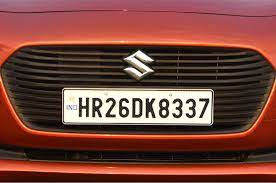

Number  identified number plate...


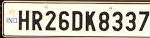

In [14]:
img = cv2.imread("/content/image2.jpg")
print("Number  input image...",)
cv2_imshow(img)

if cv2.waitKey(0) & 0xff == ord('q'):
    pass
img2 = cv2.GaussianBlur(img, (3,3), 0)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img2 = cv2.Sobel(img2,cv2.CV_8U,1,0,ksize=3)    
_,img2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
morph_img_threshold = img2.copy()
cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
num_contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
cv2.drawContours(img2, num_contours, -1, (0,255,0), 1)


for i,cnt in enumerate(num_contours):

    min_rect = cv2.minAreaRect(cnt)

    if ratio_and_rotation(min_rect):

        x,y,w,h = cv2.boundingRect(cnt)
        plate_img = img[y:y+h,x:x+w]
        print("Number  identified number plate...")
        cv2_imshow(plate_img)
        if cv2.waitKey(0) & 0xff == ord('q'):
            pass

        if(isMaxWhite(plate_img)):
            clean_plate, rect = clean2_plate(plate_img)
            if rect:
                fg=0
                x1,y1,w1,h1 = rect
                x,y,w,h = x+x1,y+y1,w1,h1
                # cv2.imwrite("clena.png",clean_plate)
                plate_im = Image.fromarray(clean_plate)
                #text = tess.image_to_string(plate_im, lang='eng')
                #print("Number  Detected Plate Text : ",text)